In [1]:
import numpy as np
#import modin.pandas as pd
import pandas as pd
from ppca import PPCA

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, FeatureAgglomeration, SpectralClustering, SpectralCoclustering, SpectralBiclustering, DBSCAN, AffinityPropagation, MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, FastICA, IncrementalPCA, KernelPCA, FactorAnalysis, TruncatedSVD, SparsePCA, MiniBatchSparsePCA, DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.manifold import TSNE, MDS, SpectralEmbedding, LocallyLinearEmbedding, Isomap
from umap import UMAP

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#import plotly_express as px

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

W0516 16:56:49.275584 4619068864 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
embed = hub.Module('universal-sentence-encoder-data')

Instructions for updating:
Colocations handled automatically by placer.


W0516 16:56:50.255296 4619068864 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
word = "Elephant"
sentence1 = "I am a sentence for which I would like to get its embedding."
sentence2 = "I am a sentence for which I would really like to get its embedding."
sentence3 = "I am a sentence for which I would not really like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence1, sentence2, sentence3, paragraph]

In [5]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(messages))

In [6]:
for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join((str(x) for x in        message_embedding[:3]))
        print("Embedding[{},...]\n".
                   format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding[0.04498474299907684, -0.05743392929434776, 0.00221146154217422,...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding[0.05568017438054085, -0.009607909247279167, 0.0062462943606078625,...]

Message: I am a sentence for which I would really like to get its embedding.
Embedding size: 512
Embedding[0.05341187119483948, -0.007404603995382786, 0.0015469718491658568,...]

Message: I am a sentence for which I would not really like to get its embedding.
Embedding size: 512
Embedding[0.04619384557008743, 0.004861076362431049, 0.0020243199542164803,...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding[0.03874940052628517, 0.0765201672911644, -0.0007945754914544523,...]



In [7]:
import seaborn as sns

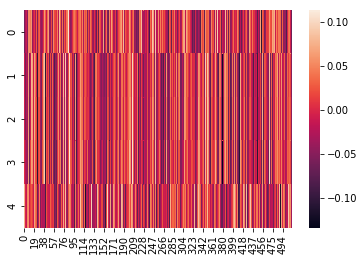

In [8]:
sns.heatmap(message_embeddings)

In [9]:
from configparser import ConfigParser
#from collections import defaultdict

In [10]:
defaults = ConfigParser()
defaults.read('defaults.ini');

In [11]:
init_notebook_mode(connected=True)

In [12]:
reduce_models = ['DictionaryLearning', 'FactorAnalysis', 'FastICA', 'IncrementalPCA', 'KernelPCA', 'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
 'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder', 'SparsePCA', 'TruncatedSVD', 'UMAP', 'TSNE', 'MDS', 'SpectralEmbedding', 'LocallyLinearEmbedding', 'Isomap']

cluster_models = ['AffinityPropagation', 'AgglomerativeClustering', 'Birch', 'DBSCAN', 'FeatureAgglomeration', 'KMeans', 'MeanShift', 'MiniBatchKMeans', 'SpectralBiclustering', 'SpectralClustering', 'SpectralCoclustering', 'DBSCAN', 'AffinityPropagation', 'MeanShift']
mixture_models = ['GaussianMixture', 'BayesianGaussianMixture', 'LatentDirichletAllocation', 'NMF']


In [13]:
def is_dataframe(x):
    return type(x).__module__ in ['pandas.core.frame', 'modin.pandas.dataframe']

def is_array(x):
    return type(x).__module__ == 'numpy'

def is_empty(x):
    return (x is None) or (len(x) == 0)        

In [14]:
def pandify(idx, cols, vals, force=False):
    if (len(idx))
    
    if (len(idx) == 0) or (idx is None):
        idx = np.arange(vals.shape[0])
    if (len(cols) == 0) or (cols is None):
        cols = np.arange(ndims)
    
    if is_dataframe(vals):
        vals = vals.copy()
        vals.index = idx
        vals.columns = cols
        return vals
    else:
        return 
    

def depandify(x):
    if is_dataframe(data):
        idx = data.index
        cols = np.arange(ndims)
        vals = data.values
    elif is_array(data):
        idx = []
        cols = []
        vals = data
    else:
        raise Exception(f'Unsupported data type: {type(data)}')
    return idx, cols, vals

    

SyntaxError: invalid syntax (<ipython-input-14-ffd2d8be60d7>, line 2)

In [ ]:
def reducer(data=None, algorithm='IncrementalPCA', ndims=3, fill_missing=False, force_pandas=False, **kwargs):
    '''
    ARGUMENTS:
    data: data to reduce (numpy array or compatable, or a pandas
          dataframe or compatable).  Formatted as a 2d matrix whose
          rows are observations and whose columns are feature
          dimensions.
    
    force_pandas: if True, force the result to be a pandas dataframe;
          if False (default), return the inputs in the same format
          as they were provided (unless stack=True, in which case
          force_pandas is reset to True).
    
    algorithm: one of: 'DictionaryLearning', 'FactorAnalysis',
          'FastICA', 'IncrementalPCA', 'KernelPCA',
          'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
          'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder',
          'SparsePCA', 'TruncatedSVD', or 'UMAP'.  Calls the
          relevant scikit-learn or UMAP function.  Can also
          pass a function directly.
    
    ndims: the number of dimensions (columns) in the result (default: 3).
          if ndims > data.shape[1], the right-most columns will be
          zero-padded.
    
    fill_missing: if True, use PPCA to fill in nan-valued entries
    
    all additional keyword arguments are passed to the reduce algorithm
    
    RETURNS:
    numpy array or pandas dataframe with number-of-observations rows and
    ndims columns
    '''
    if type(algorithm) == str:
        assert algorithm in reduce_models, f'Unknown algorithm: {algorithm}' #security check to prevent executing arbitrary code
        algorithm = eval(algorithm)
    else:
        if ('sklearn.decomposition' in algorithm.__module__) or ('umap.umap_' in algorithm.__module__):
            pass #algorithm already given as a function
    assert ndims >= 0, f'Number of dimensions must be non-negative (given: {ndims})'
    
    import warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    if fill_missing:
        raise(NotImplementedError('call PPCA and/or use interpolation to fill in missing values'))
    
    if data.shape == ndims:
        return data
    
    if is_dataframe(data):
        idx = data.index
        cols = np.arange(ndims)
        vals = data.values
    elif is_array(data):
        idx = []
        cols = []
        vals = data
    else:
        raise Exception(f'Unsupported data type: {type(data)}')
    
    if force_pandas:
        if len(idx) == 0:
            idx = np.arange(vals.shape[0])
        if len(cols) == 0:
            cols = np.arange(ndims)
    
    if vals.shape[1] > ndims:
        model = algorithm(n_components=ndims, **kwargs)
        reduced_vals = model.fit_transform(vals)
    elif vals.shape[1] < ndims:
        reduced_vals = np.concatenate([vals, np.zeros([vals.shape[0], ndims-vals.shape[1]])], axis=1)
    else:
        reduced_vals = vals
    
    if is_dataframe(data) or force_pandas:
        return pd.DataFrame(data=reduced_vals, index=idx, columns=cols)
    else:
        return reduced_vals

In [ ]:
def batch_reducer(data=None, stack=False, names=None, **kwargs):
    '''
    ARGUMENTS:
    data: a numpy array (or compatable), pandas dataframe 
          (or compatable), or a list of arrays and/or dataframes.
          If multiple matrices are passed (e.g. in a list), they
          must all have the same number of columns.
    
    stack: should the answer be returned as a list (stack=False,
          default) or a single multiindexed pandas dataframe
          (stack=True)?
    
    names: a list or array of strings, of the same length as data
          (or, if data isn't a list, just a single string),
          describing each dataset (e.g. for use in a legend)
    
    force_pandas: if True, force the result to be a pandas dataframe;
          if False (default), return the inputs in the same format
          as they were provided (unless stack=True, in which case
          force_pandas is reset to True).
    
    algorithm: one of: 'DictionaryLearning', 'FactorAnalysis',
          'FastICA', 'IncrementalPCA', 'KernelPCA',
          'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
          'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder',
          'SparsePCA', 'TruncatedSVD', or 'UMAP'.  Calls the
          relevant scikit-learn or UMAP function.  Can also
          pass a function directly.
    
    all additional keyword arguments are passed to the reduce algorithm
    
    RETURNS:
    
    One or more reduced-dimensional matrices (each of shape
    number-of-observations by ndims), in the same format as the inputted
    data (or as pandas dataframes if force_pandas is True).  Or, if 
    stack=True, return a single multilevel dataframe.    
    '''
    if not type(data) == list:
        reduced = batch_reducer(data=[data], stack=stack, names=names, **kwargs)
        if stack:
            return reduced
        else:
            return reduced[0]
    
    assert len(np.unique([x.shape[1] for x in data])) == 1, 'All datasets must have the same number of columns'
    assert np.all([np.ndim(x) == 2 for x in data]), 'All datasets must be 2d arrays, matrices, or DataFrames'
    
    rows = list(np.cumsum([x.shape[0] for x in data]))
    rows.insert(0, 0)
    
    #there's probably a cleaner way to do this...
    if (('force_pandas' in kwargs.keys()) and kwargs['force_pandas']) or stack:
        force_pandas = True
        for i, d in enumerate(data):
            if not is_dataframe(d):
                data[i] = pd.DataFrame(data=d, index=np.arange(d.shape[0]), columns=np.arange(d.shape[1]))
    else:
        force_pandas = False
    
    modules = [type(x).__module__ for x in data]
    idx = []
    for i, d in enumerate(data):
        if is_dataframe(d):
            idx.append(d.index)
            data[i] = data[i].values
        else:
            idx.append([])
    
    x_combined = reducer(np.concatenate(data, axis=0), **kwargs)
    if names is None:
        names = np.arange(len(data), dtype=np.int)
    
    if stack: #put everything into a multilevel index
        groups = np.zeros(x_combined.shape[0])
        for i, j in enumerate(rows[:-1]):
            groups[j:rows[i+1]] = names[i]
        idx = pd.MultiIndex.from_arrays([groups, [j for i in idx for j in i]], names=('ID', 'Observation'))
        return pd.DataFrame(data=x_combined.values, index=idx, columns=np.arange(x_combined.shape[1]))
    
    x_split = []
    for i, j in enumerate(rows[:-1]):
        if is_dataframe(x_combined):
            x = x_combined.iloc[j:rows[i+1], :].values
        else:
            x = x_combined[j:rows[i+1], :]
        
        if is_dataframe(data[i]):
            x_split.append(pd.DataFrame(data=x, index=idx[i], columns=np.arange(x.shape[1])))
        else:
            x_split.append(x)
    return x_split

In [ ]:
def clusterer(data=None, algorithm='IncrementalPCA', ndims=3, fill_missing=False, force_pandas=False, **kwargs)

In [ ]:
def plotter(data, style='line', reduce_kwargs={}, **kwargs):
        
    def combo_merge(a, b):
        combos = []
        for i in a:
            for j in b:
                if (len(i) <= 2):
                    if (len(j) <= 2):
                        combos.append(i+j)
                elif len(j) > 1:
                    combos.append(i + '+' + j)
        return combos
    
    marker_styles = ['.', 'o', 'scatter', 'marker', 'markers', 'bigmarker', 'bigmarkers']
    line_styles = ['-', '--', ':', 'line', 'lines']
    combo_styles = combo_merge(marker_styles, line_styles) + combo_merge(line_styles, marker_styles)
    big_markers = ['o', 'big']
    dash_styles = {'--': 'dash', ':': 'dot'}
    
    def substr_list(style, x):
        '''
        style: a style string
        x: a list of substrings
        
        return: true if any of the strings in x is a substring of s, and false othewise    
        '''
        inds = np.array([s in style for s in x])
        if np.any(inds):
            return x[np.where(inds)[0][0]]
        else:
            return ''
    
    is_line = lambda s: substr_list(s, line_styles + combo_styles)
    is_marker = lambda s: substr_list(s, marker_styles + combo_styles)
    is_combo = lambda s: substr_list(s, combo_styles)
    
    is_dashed = lambda s: substr_list(s, list(dash_styles.keys()))
    is_bigmarker = lambda s: substr_list(s, big_markers)
    
    reduced_data = batch_reducer(data, force_pandas=True, stack=True, **reduce_kwargs)
    split_data = [x[1].set_index(x[1].index.get_level_values(1)) for x in list(reduced_data.groupby('ID'))]
    
    if reduced_data.shape[1] == 2:
        suffix = ''
    elif reduced_data.shape[1] == 3:
        suffix = '3D'
    else:
        raise NotImplementedError(f'Unsupported number of dimensions; reduced data must be 2d or 3d, given: {reduced_data.shape[1]}')
        
    
    
    #TODO: add support for multiple styles (up to one per line)
    #TODO: load in custom plot theme/style from defaults, also allow user to customize
    #TODO: draw bounding box around space
    #TODO: support animation:
    # - camera rotation
    # - window length around current timepoint
    # - opacity of prior timepoints
    # - opacity of current window
    # - opacity of future timepoints    
    #TODO: legend customization
    #TODO: label each point with its original values and/or a user-specified label
    #TODO: support per-datapoint colors, including for lines
    #TODO: support for mixture-based colors-- if 1d, map onto colormap.  If 1 < n-colors <= 3, pick
    #      a color for each dimension and then compute each coordinate as a weighted blend.  If > 3,
    #      map onto 3D colors and then treat as 3D.  Can also define custom functions-- should take
    #      in any observation and return a new vector describing its color (in >= 1D).  also support
    #      a list of functions (one per data matrix)
    #TODO: support plotting of error bars via streamtubes and/or ribbon plots
    #TODO: support plotting "vector fields" by taking a list of two matrices of coordinats,
    #      one specifying the start points and the other specifying the end points of each
    #      vector
    
    #Write a general "hypertools function" that does all analyses by calling normalize --> align --> reduce
    #in sequence.
    
    #TODO: support for nested (>2 level dataframes)
    #TODO: support interpolation for line_styles and combo_styles
    #TODO: define default options outside of this function in a dictionary
    #TODO: normalization options: z-score down rows, across columns, both, or arbitrary functions (take
    #      in a data matrix and return a new matrix of the same type/size).  can also provide lists of
    #      normalization functions to be applied separately to each data matrix.
    #TODO: add support for multiple reduce functions (and/or reduce_kwargs)-- one per data matrix
    #TODO: add hyperalignment and SRM.  also allow different subsets of the data to be aligned, e.g.
    #      according to the unique IDs specified in a list of group IDs, some column of the data matrix,
    #      cluster IDs, or a custom function (or a dictionary of functions specifying how different
    #      group IDs should be aligned); functions should take in a list of data matrices and returned an aligned
    #      list in the same format.
    
    style = style.lower()
    
    assert style in marker_styles + line_styles + combo_styles, f'Unsupported plot style: {style}'
    
    if is_combo(style):
        mode='lines+markers'
    elif is_line(style):
        mode='lines'
    else:
        mode='markers'
    
    if is_line(style):
        if not('line' in kwargs.keys()):
                kwargs['line'] = {}
        if not('opacity' in kwargs['line'].keys()):
            kwargs['line']['opacity'] = float(defaults['plot']['opacity'])
        
        dash = is_dashed(style)
        if dash:
            if not('dash' in kwargs['line'].keys()):
                kwargs['line']['dash'] = dash
    if is_marker(style):
        if is_bigmarker(style):
            size = int(defaults['plot']['bigmarkersize'])
        else:
            size = int(defaults['plot']['markersize'])
        
        if not('marker' in kwargs.keys()):
            kwargs['marker'] = {}
        if not('size' in kwargs['marker'].keys()):
            if is_bigmarker(style):
                kwargs['marker']['size'] = int(defaults['plot']['bigmarkersize'])
            else:
                kwargs['marker']['size'] = int(defaults['plot']['markersize'])        
        if not('opacity' in kwargs['marker'].keys()):
            kwargs['marker']['opacity'] = float(defaults['plot']['opacity'])            
    
    names = [str(n) for n in np.array(reduced_data.index.levels[0])]
    
    if reduced_data.shape[1] == 2:
        shapes = [go.Scatter(x=d.iloc[:, 0], y=d.iloc[:, 1], mode=mode, name=names[i], **kwargs) for i, d in enumerate(split_data)]
    elif reduced_data.shape[1] == 3:
        shapes = [go.Scatter3d(x=d.iloc[:, 0], y=d.iloc[:, 1], z=d.iloc[:, 2], mode=mode, name=names[i], **kwargs) for i, d in enumerate(split_data)]
    
    return iplot(shapes)

In [ ]:
xs = [np.cumsum(np.random.randn(100, 10), axis=0) for i in np.arange(10)]

In [ ]:
x_r = batch_reducer(xs, algorithm='UMAP')

In [ ]:
plotter(xs, '.')

In [ ]:
plotter(xs, style='--o')

In [ ]:
plotter(xs, style='-o')

In [ ]:
plotter(xs, style='.', reduce_kwargs={'ndims': 2})

In [ ]:
plotter(xs, style='-', reduce_kwargs={'ndims': 2})

In [ ]:
#https://plot.ly/python/line-charts/

In [ ]:
names = [str(s) for s in np.arange(len(x_r))]
data = [go.Scatter(x=x_r[i][:, 0], y=x_r[i][:, 1], mode='markers', name=n) for i,n in enumerate(names)]
iplot(data)

In [ ]:
names = [str(s) for s in np.arange(len(x_r))]
data = [go.Scatter(x=x_r[i][:, 0], y=x_r[i][:, 1], mode='lines', name=n) for i,n in enumerate(names)]
iplot(data)

In [ ]:
iplot(data)

In [ ]:
names = [str(s) for s in np.arange(len(x_r))]
data = [go.Scatter3d(x=x_r[i][:, 0], y=x_r[i][:, 1], z=x_r[i][:, 2], mode='markers', name=n) for i,n in enumerate(names)]
iplot(data)

In [ ]:
names = [str(s) for s in np.arange(len(x_r))]
data = [go.Scatter3d(x=x_r[i][:, 0], y=x_r[i][:, 1], z=x_r[i][:, 2], mode='lines', name=n) for i,n in enumerate(names)]
iplot(data)